In this notebook, I'll demonstrate how to use the genetic algorithm (GA) tool in BPReveal. 
Before plunging into the code, I'll briefly describe what a GA is, and then we'll consider a biological problem
where a GA could be appropriate. 


# What is a GA?
Let's say you have some complicated process with lots of settings to configure. 
You want to choose the best possible combination of settings for your process. 
For example, a company might want to know the optimal price to charge for each of its products in order to maximize profit. 
A chemical engineer might want to choose the best flow rates and temperatures of reagents into a reactor in order to maximize yield. 
In our case, we want to find a way to change a DNA sequence so that it behaves in some desired way. 

We could imagine a few ways to go about picking optimal settings. 
One option would be to just try a bunch of random settings and choose the one that does best. 
Alternatively, you could try changing one setting a tiny amount to see if it improves the performance of the process.
Or you could call in an expert, and ask for their advice, or any number of other strategies. 

The task of choosing a good configuration of settings is called an optimization problem, and a GA is one way to tackle an optimization problem.
GAs are inspired by evolution, where you have a population of organisms, and those organisms that are well-suited to their environment will tend to produce more offspring.

Unlike actual evolution, though, each "organism" in a GA is a particular configuration of settings for the process, and the ability of an organism to produce offspring is linked to how well that process performs when you use those settings. 
In this way, good configurations of settings will gradually displace bad ones in the population. 

But if we just always picked good organisms and cloned them, then this strategy would just pick the best organism among the original population, only with a lot of added, unnecessary steps. 
So we steal another idea from biology: mutation and crossover. 
When an organism produces offspring, they won't be identical copies; they will have random mutations relative to the parent's configuration of settings. 
Similarly, we can take two organisms and combine their settings vectors to produce offspring that have the good parts of both parents. (Or the bad parts of both parents since mixing happens at random.)

By repeatedly creating offspring from the best organisms in the population, the genetic algorithm will drift toward better and better configurations of settings. 

I should define a few terms that will come up again and again. 

- An "organism" is a particular combination of settings for the process we're considering. If we were considering the example of a company choosing good prices for its products, one organism would be a list of prices, one for each product. 
- The "fitness function" is a way to determine how effective a particular organism is for the process you're considering. For the company choosing prices, the fitness function would take in a list of prices (i.e., an organism) and model what the company's total profit would be. Very often, it's not feasable to use the actual process during the optimization. For example, a company wouldn't actually change the prices of their products as they're choosing the best prices; instead they'd build some sort of economic model and use that for the fitness. In our case, where we're evolving a DNA sequence that accomplishes something, it's not feasible to go in the lab and perform a million mutation experiments, but we can use a model like BPReveal to predict the outcome of those experiments. 
- A "population" is just a bunch of organisms.
- A "mutation" operator takes a particular configuration of settings (i.e., organism) and randomly perturbs it. The mutation operator has no idea if it's making a good choice, just like how real mutations in biology don't occur with any forethought as to their effect. 
- A "mixing" operator takes two parent organisms and combines their settings in some way to produce a child that has aspects of both parents. 
- A "selection" operator takes a population of organisms and selects one or two for mutation or mixing, respectively. This is where we implement survival of the fittest - the selection operators tend to choose better organisms among the population (based on the fitness function) and so those organisms will produce more offspring. 

There are some other terms that show up in GA literature, but these will be enough to get us started. 

# The BPReveal GA module
I've implemented a relatively straightforward GA tool in BPReveal, and you can use it to evolve a sequence to have some desired property (i.e., fitness function)
You're on your own for coming up with a fitness function. You must understand your biology in order to know what you want the GA to produce. 
For the rest of the operators, like mutation and selection, I provide some sensible defaults. If you want to change them, you can subclass the Population and Organism classes in your own code, but that's a more advanced topic. 

But first, I need to explain what an organism is. The goal of the GA module is to evolve a DNA sequence to have some desired outcome. 
So, naturally, an "organism" in this context would be a sequence of DNA, and the mutation and mixing operators would mirror real-life mutation and crossover events, right? 

WRONG!

The problem with doing that is that the GA has no idea if it's coming up with biologically plausible sequences. If it comes up with something totally out-of-distribution for the BPReveal model, then the model will make up some result that has no basis in reality. 
So I need some way to restrain the GA so that it always stays in the vicinity of a reasonable sequence. 

I do this by changing the settings that an organism represents. 
Instead of the settings vector representing the whole DNA sequence, it instead gives a list of operations, and that list is of a fixed length.
The allowed operations are SNPs, insertions, and deletions, and I call any of these operations a "corruptor". 
It's a sort of weird word, but otherwise I wind up talking about "mutate one mutation into a mutated mutation" and it gets messy. 
In this document, a "mutation" always refers to the GA operator that takes an organism and randomly changes one of its corruptors, thus producing a new organism.
If I want to talk about changing one base to a different letter, I will always call that a SNP, not a mutation. 

So an organism would be something like "Change base 32 to C, delete base 45, and add an A after base 63."
The way I'm representing these changes, this organism would look like `((32, "C"), (45, "d"), (63, "Ǎ"))`. 

So in order to use this tool, you first must give it a list of possible corruptions that it can make to the base sequence. 
For example, you might want to restrict corruptors to a region of DNA that you think is interesting. 
You could also forbid corruptors that introduce a particular motif that you don't want. 
There is a tool in the module, `getCandidateCorruptorList`, that will generate these automatically, but you can of course generate them yourself if you have an idea of what corruptors to consider. 
You also need to choose how many corruptors you want to allow. 
This is a parameter that you set, and the space of possible combinations of corruptors grows explosively as you increase this parameter. 
This means that the GA has more options that it can use to maximize your fitness function, but also that it will generally take longer to find a good one. 

I tried to include sensible defaults for the operators in this tool, and here's what I came up with: 

The default mutation operator takes one organism and replaces one of its corruptors (chosen at random) with a different one (chosen at random from the set of all possible corruptors). There is some logic to make sure it doesn't mutate the same base twice, but it is generally very permissive. 

The default mixing operator combines all of the corruptors from the parent organisms, and then randomly selects enough from that combined pool to make a child organism. 
Again, there is some logic in place to make sure that the chosen pool of corruptors is valid.

The default selection operators are based on a simple triangular distribution, where the probability of an organism being selected is a linear function of its rank among all the organisms. 

# Setup: The boring part
Here, I'm just loading up the modules and generating the predictor. 
I'll also show off how to use a predictor, since it abstracts away a lot of the messy model loading stuff into a simple interface.

In [1]:
# Boring imports, setting up the path.
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tqdm

In [2]:
# More boring imports.
import bpreveal.utils as utils
utils.setMemoryGrowth()
import bpreveal.gaOptimize as gaOptimize
import numpy as np
import pysam
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,8]

In [3]:
# I'm going to be optimizing part of the Pho5 promoter, which is located here:
OUTPUT_START=430700
OUTPUT_END=OUTPUT_START+1000
INPUT_LENGTH=3092  # This is the input length of my model.
BUFFER=(INPUT_LENGTH - 1000)//2
INPUT_START=OUTPUT_START - BUFFER
INPUT_END=INPUT_START+INPUT_LENGTH

# I've copied the model from the pisa subtraction bias correction work into this
# directory, I'll use it to make predictions. 
MODEL_FNAME="demo/models/yeast_mnase_residual.model"
GENOME_FNAME="/n/data1/genomes/S_cerevisiae/sacCer3/all_chr.fa"
# I'm allowing ten corruptors in an organism.
NUM_CORS=10
POP_SIZE=3000
NUM_GENERATIONS=1000

with pysam.FastaFile(GENOME_FNAME) as genome:
    ORIG_SEQUENCE=genome.fetch("chrII", INPUT_START, INPUT_END + NUM_CORS)

In [4]:
# Load the predictor
predictor = utils.BatchPredictor(MODEL_FNAME, 64)

In [5]:
# Just to show how the predictor works, I'll use it here on the wild-type 
# sequence. You give it a string representing your sequence, along with 
# a label, which can be any object. In this case, my label is the integer 1.
predictor.submitString(ORIG_SEQUENCE[:INPUT_LENGTH], 1)

In [6]:
# Once I've submitted any strings I'm interested in, I can pull them out. 
ret = predictor.getOutput()

In [7]:
print(ret)

([array([[-1.6079909e+00, -1.8675719e+00],
       [-1.5562079e+00, -1.6157023e+00],
       [-1.5800401e+00, -1.7469832e+00],
       ...,
       [ 9.4929171e-01, -3.9698452e-02],
       [ 9.8696756e-01,  2.3111768e-02],
       [ 1.0384007e+00, -1.8020421e-03]], dtype=float32), 10.451029777526855], 1)


The shape of the output from the predictor is a two-tuple. The first element is the output of the network, 
and the second is the label you passed in when you submitted it. 
The predictor does *not* guarantee that the outputs will be in the same order as your submissions, 
since it could run them on multiple processes. 

The output is basically copied directly from the model, but with the batch-size dimension removed. 
For a model with $k$ heads, the structure will be $k$ arrays of the logits from the heads, followed by $k$ floating point numbers, giving the logcounts for each head.
The logits array will have shape (output-length x num-tasks). 

In [8]:
logits, logcounts = ret[0]
profile = utils.logitsToProfile(logits, logcounts)

Text(0, 0.5, 'mnase endpoints')

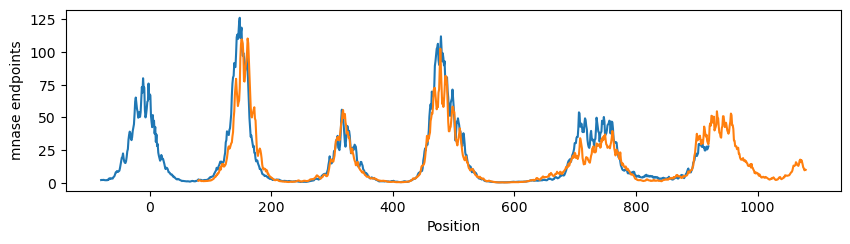

In [9]:
# This offset business is particular to how I'm processing mnase data. 
# My models are trained on endpoints, so I shift the peaks by 80 bp 
# to reflect approximately where the dyads would be. 
offset = -80
plt.subplot(311)
plt.plot(range(offset,1000+offset), profile[:,0])
plt.plot(range(-offset, 1000-offset), profile[:,1])
plt.xlabel("Position")
plt.ylabel("mnase endpoints")

# Setup: The interesting part
Here, I'll create the GA and also define the fitness function. 

In [10]:
# Here's my fitness function. In this case, I want to minimize the density 
# of reads between 450 and 550, which corresponds to the N-2 nucleosome 
# in the Pho5 promoter. 
def fitnessSuppressSecond(preds, cors):
    logits, logcounts = preds
    profile = utils.logitsToProfile(logits, 0)
    fivePrime = np.sum(profile[450+offset:550+offset,1])
    threePrime = np.sum(profile[450-offset:550-offset,0])
    # Note that fitness should be large for good organisms, and low for
    # bad ones. This is the opposite of how loss is defined in neural networks.
    return 1 - (fivePrime + threePrime)

In [11]:
# Allow any corruptors that are within the output window. (by default, this 
# will allow any corruptors in the input window, and that just takes a 
# very long time to optimize since there are so many options.)
corList = gaOptimize.getCandidateCorruptorList(ORIG_SEQUENCE, regions=[[BUFFER, len(ORIG_SEQUENCE)-BUFFER]], allowDeletion=True, allowInsertion=True)

In [12]:
print(corList[:10])

[(1046, 'CGTdǍČǦŤ'), (1047, 'ACTdǍČǦŤ'), (1048, 'CGTdǍČǦŤ'), (1049, 'AGTdǍČǦŤ'), (1050, 'ACGdǍČǦŤ'), (1051, 'ACTdǍČǦŤ'), (1052, 'CGTdǍČǦŤ'), (1053, 'AGTdǍČǦŤ'), (1054, 'CGTdǍČǦŤ'), (1055, 'ACTdǍČǦŤ')]


## The candidate corruptor list
This list may look intimidating, mostly due to the accented letters. I used carons because they look like little insertion marks. 
If you're editing text in `vim` (which you should), you can access these letters through these digraph sequences: `<C-k>A<`, `<C-k>C<`, `<C-k>G<`, and `<C-k>T<`, where `<C-k>` means press control-k, and `A<` means type those two letters. Sorry that I'm using `<` as both a control sequence delimiter and a typed letter, but that's how it's typically represented. 

The candidate corruptor list gives every allowed corruptor for your sequence. For example, `(1048, 'CGTdǍČǦŤ')` means that there are eight things you can do th position 1048:
- Change that base to C
- Change that base to G
- Change that base to T
- Delete that base
- Insert an A after that base
- Insert a C after that base
- Insert a G after that base
- Insert a T after that base. 



In [13]:
# Now we're ready to set up the population. 
pop = gaOptimize.Population(ORIG_SEQUENCE, INPUT_LENGTH, POP_SIZE, 
                            NUM_CORS, corList, lambda x:True,
                            fitnessSuppressSecond, 1, predictor)

The arguments to Population are, in order:
- The base sequence. An organism will apply its corruptors to this base sequence at every generation. In other words, the base sequence does not evolve, just the list of corruptors. Note the need for the base sequence to be longer than INPUT_LENGTH, because deletions are valid coruptors, and you need to provide enough sequence to fill in the flanks if deletions are applied. 
- The input length for the model. Since ORIG_SEQUENCE will have some slop on the end, the GA will trim all the outputs from the organisms down to this length before calling the model.
- The size of the population. I can't give you a hard-and-fast rule here, but I find the GA works most efficiently when the population size is about a quarter of the number of generations. 
- The number of corruptors in each organism. You have to choose this for your own problem. A higher number gives the GA more flexibility, but it also means that the sequences it derives can be further away from a biologically plausible sequence. Additionally, the search space grows exponentially with more corruptors, so the algorithm will converge much more slowly.
- The list of all allowed corruptors. This is in the format returned by getCandidateCorruptorList. 
- A function that determines if a given list of corruptors is allowed. If you want to prevent the introduction of a particular motif, for example, you could use this function to prevent its addition. If you don't want to apply restrictions, pass in a function that always returns True, like the one I'm using here.
- The fitness function. 
- The elitism. This is the number of parents that survive from generation to generation. We want to keep at least the best parent from each generation, so that we don't discard an optimal solution. But we don't want to keep all the parents, because then the population would stagnate. I typically keep the single best parent, and that seems to work pretty well. 
- The predictor that you initalized for your model. 

# Running the GA

In [14]:
# I have to runCalculation once before I can call nextGeneration. 
# runCalculation takes all the organisms, runs them through the BPReveal
# model, and scores them with the fitness function. 
# If this were not called, then the selection operators wouldn't know which
# organisms to choose for the next generation. 
pop.runCalculation()

# Each time I set a fitness record, I'm going to track it. This isn't 
# necessary in production, but for demonstrating the GA, it's nice to
# see the organisms that the GA invented during the optimization. 
recordProfiles = []
recordScores = []
recordCorruptors = []
recordGenerations = []
fitnessArray = []

# Now it's time to actually run the GA. 
bestScore = -10000000
pbar = tqdm.tqdm(range(NUM_GENERATIONS))
for i in pbar:
    pop.nextGeneration()
    pop.runCalculation()
    # Only for showing, this is dumb to do in production. 
    allFitnesses = [x.score for x in pop.organisms]
    fitnessArray.append(allFitnesses)
    if(pop.organisms[-1].score > bestScore):
        bestScore = pop.organisms[-1].score
        recordProfiles.append(pop.organisms[-1].profile)
        recordScores.append(bestScore)
        recordGenerations.append(i)
        recordCorruptors.append(pop.organisms[-1].corruptors)
        pbar.set_description("Gen {0:d} fitness {1:f}".format(i, bestScore))

Gen 384 fitness 0.996405: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:36<00:00,  1.44it/s]


# Inspecting the results
Let's take a look at what the GA invented!

In [20]:
print(recordCorruptors[-1])

[(1503, 'T'), (1507, 'A'), (1531, 'Ť'), (1545, 'Ť'), (1551, 'A'), (1552, 'Ǎ'), (1556, 'A'), (1568, 'A'), (1620, 'Ǧ'), (1649, 'Ǎ')]


It looks like it settled on three SNPs, three insertions, and one deletion. 
I've added a little plotting utility to gaOptimize that adds pips for each corruptor, and can also add blocks for annotated regions.

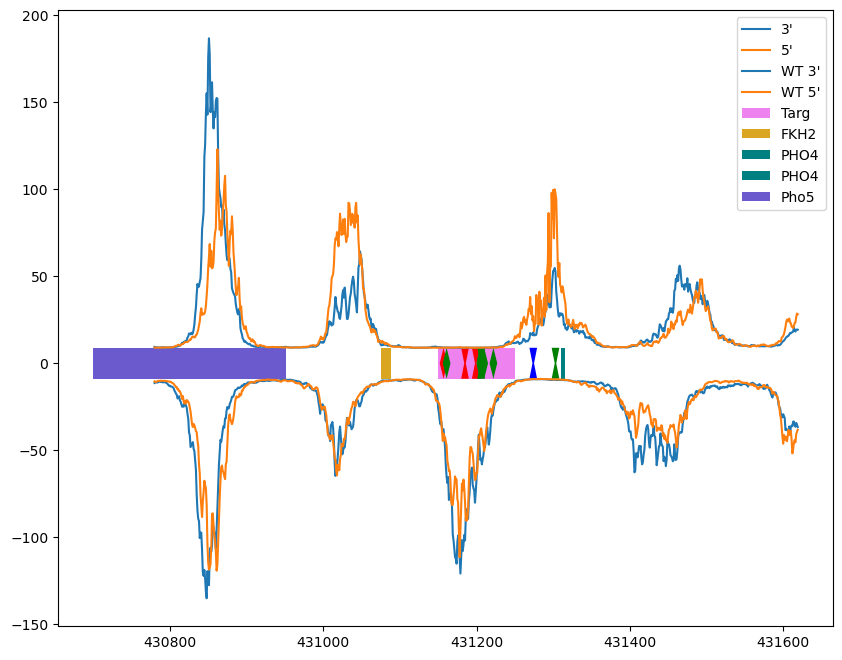

In [21]:
fig = plt.figure()
ax=fig.add_subplot()

# There are a few motifs I want to annotate, as well as the Pho5 gene itself. 
# I'm also putting up a box that reflects the area that my fitness 
# function was trying to tamp down. 
annotations = [
    ((OUTPUT_START+450, OUTPUT_START+550), "Targ", "violet"),
    ((431075, 431089), "FKH2", "goldenrod"),
    ((431200, 431206), "PHO4", "teal"),
    ((431310, 431316), "PHO4", "teal"),
    ((430700, 430951), "Pho5", "slateblue")]

# Get the actual profiles for the best organism and the original sequence. 
logits, logcounts = pop.organisms[-1].profile
profile = utils.logitsToProfile(logits, logcounts)
oldLogits, oldLogcounts = ret[0]
oldProfile = utils.logitsToProfile(oldLogits, oldLogcounts)
# In order to add pips for the corruptors, I need to have them at the 
# correct X coordinates. The numbers in the corruptors are relative to the 
# start of the input, and the plot will be relative to the genome itself. 
cors = recordCorruptors[-1]
corsRepositioned = [(x[0] + INPUT_START, x[1]) for x in cors]
# I'm shifting the profiles again so that we have a sense of where 
# the midpoints would be.
gaOptimize.plotTraces(
    [  (profile[160:,0], "3'", "tab:blue"),
       (profile[:-160,1], "5'", "tab:orange")],
    [  (oldProfile[160:,0], "WT 3'", "tab:blue"),
       (oldProfile[:-160,1], "WT 5'", "tab:orange")],
    range(OUTPUT_START+80, OUTPUT_END-80),
    annotations, corsRepositioned, ax)

Cool! Note that the a lot of the GA's preferred corruptors are outside of the area that the fitness function cared about. 
We can also see that it has shifted the remaining nucleosomes a bit out of phase, and completely destroyed the previous NDR.
This shows not only what's good about using a GA, but also what's bad about it. 
What I really wanted was for the GA to remove the target nucleosome but leave the others intact. 
Unfortunately, I didn't specify that second part in my fitness function, and the GA found that the best
way to get rid of the target nucleosome involved shifting all the others around. 

How do I get around this? Well, I need to go back to my fitness function, and add a new term that rewards
the GA for organisms that keep the other nucleosomes intact. I could try to check for correlation with the previous profile, for example.
Alternatively, I could decide that I really want the mutations to occur under the nucleosome in question, and not in its flanks. 
To do this, I could prune down the candidate corruptor list to only allow a subset of the bases. 

In [22]:
# I'm going to plot the progress of the best organism during the calculation. 
# Normally, you wouldn't do this, since you only care about the best organism, 
# not all the previous ones. 

# The profile of each record organism.
rp = np.zeros((len(recordProfiles)+1, 1000))
rp[0] = oldProfile[:,0]
for i in range(len(recordProfiles)):
    logits, logcounts = recordProfiles[i]
    profile = utils.logitsToProfile(logits, logcounts)
    rp[i+1] = profile[:,0]
# The position of each corruptor in the record organism.
corPoses = np.zeros((len(recordCorruptors), INPUT_LENGTH))
for i in range(len(recordCorruptors)):
    for c in recordCorruptors[i]:
        p = c[0]
        decode = dict((v,k) for k,v in enumerate("ACGTdǍČǦŤ"))
        val = decode[c[1]]
        corPoses[i, p] = val

# Since the set of possible corruptor positions is large, I'm going to remove 
# any positions that never had a corruptor, just so it's easier to see. 
corCols = []
for c in range(INPUT_LENGTH):
    if(np.sum(corPoses[:,c]) > 0):
        corCols.append(corPoses[:,c])

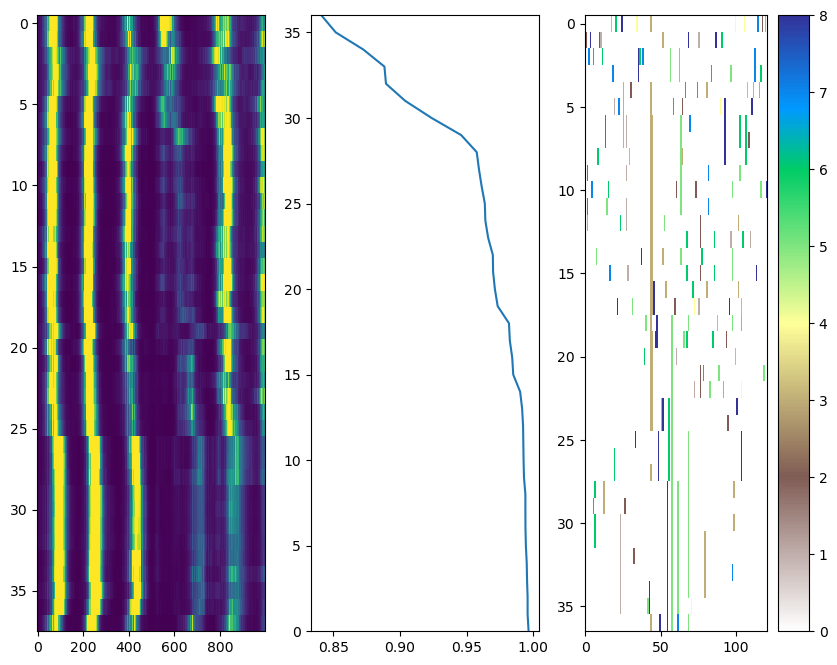

In [23]:
plt.subplot(131)
plt.imshow(rp, aspect='auto', interpolation='nearest', vmin=0, vmax=50)
plt.subplot(132)
plt.plot(recordScores[::-1], range(len(recordScores)))
plt.ylim(0, len(recordScores)-1)
plt.subplot(133)
plt.imshow(np.array(corCols).T, aspect='auto', 
           cmap='terrain_r', interpolation='nearest')
plt.colorbar()

The left plot shows the profile (well, 3' cut sites) at each record. 
Note that the change is explosive from the first iteration, and then the optimization slows down. 
The middle track shows the fitness at each record. 
The final track shows the location of the mutations. 

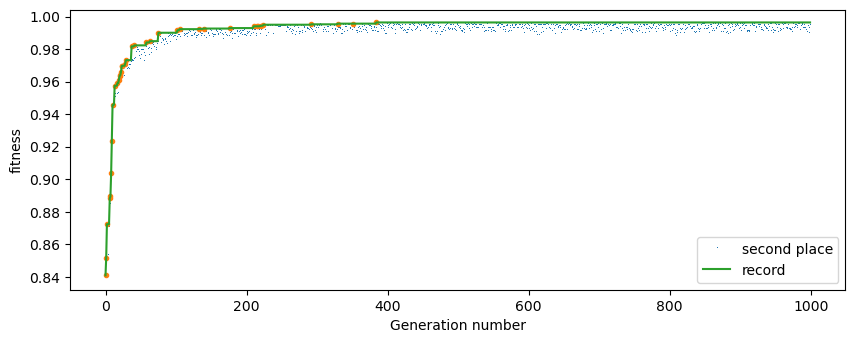

In [24]:
plt.subplot(211)
plt.plot(np.array(fitnessArray)[:,-2], ',', label='second place')
plt.plot(recordGenerations, recordScores, '.')
plt.plot(np.array(fitnessArray)[:,-1], label='record')

plt.xlabel("Generation number")
plt.ylabel("fitness")
plt.legend()

It's interesting that the GA seems to have bursts of innovation. It starts of with giant leaps in fitness,
and then after generation 180, it takes an eternity for it to discover something around 380. Once it does
that, though, it's off to the races and there are a bunch of mutations that appear.